## Mini Chess Solver Using Dynamic Programming - Total 7 Marks

### Problem Statement

Design and implement a reinforcement learning agent using dynamic programming (value iteration or policy iteration) to compute an optimal policy for a simplified chess game. The agent plays as White and must learn how to convert an advantage into a win or at least avoid a loss in a MiniChess game against a defensive opponent. The problem must be modelled as a finite MDP. Register number of first student in a group (alphabetically sorted) will be considered for configuration design.
The student will:
* Implement a custom Mini Chess environment.
* Use dynamic programming to compute the optimal value function and policy.
* Analyze how state design and reward shaping affect the learned policy and convergence.

### Scenario

You are building a “Mini Chess Game” for beginner players. The coach focuses on a small, tractable game:
* White: King + Pawn
* Black: King
* Board: 4×4 or 5×5 MiniChess board
* White moves first and tries to either:
    * Promote the pawn and then deliver checkmate, or
    * Force a checkmate directly (if possible)

Black tries to prevent this by blocking the pawn, chasing the white king, or capturing the pawn. The game is restricted to this small set of pieces and a tiny board.

### Environment Description
#### Board and Pieces
* Board size:
    * If the student roll number / registration number is even: use a 4×4 board (rows 0–3, cols 0–3).
    * If odd: use a 5×5 board (rows 0–4, cols 0–4).
* Pieces always present:
    * White King (WK)
    * White Pawn (WP)
    * Black King (BK)
    * No castling, no en passant, no promotion to anything other than Queen.
* Legal Moves
    * Kings move like normal chess kings - one square in any direction (8- neighborhood), staying on the board.
    * Pawn:
        * Moves one square forward (towards larger row index or smaller row index – the student must choose and clearly document a convention).
        * Captures diagonally forward by one square.
    * All usual constraints apply:
        * Kings cannot move into check.
        * Two kings may never occupy adjacent squares (illegal state).
        * A piece cannot move through other pieces.
* Episode Termination
    * An episode ends when any of the following happens:
        * Checkmate (White checkmates Black).
        * Stalemate (side to move has no legal moves but is not in check).
        * Pawn Capture (Black captures the White pawn).
        * Pawn Promotion (White pawn reaches last rank and becomes a Queen). After promotion, they may either:
                * (a) terminate immediately with a reward, or
                * (b) continue playing with a Queen replacing the pawn.
        * The student must choose one approach and justify it.
        * Move limit exceeded (e.g., 20 or 30 plies) – draw
1. State Space

* Each state should minimally encode:
    * Coordinates of WK: (r_wk, c_wk)
    * Coordinates of WP (or a special value if promoted/captured): (r_wp, c_wp) or status flag
    * Coordinates of BK: (r_bk, c_bk)
    * Player to move: {White, Black}
    * Any additional flags that can be necessary like,
        * Has the pawn promoted?
        * Check / checkmate / stalemate indicators.
* The student must:
    * Describe the state representation clearly.
2. Action Space
    * For each state, actions are the legal moves for the side to move:
        * Move King to a legal square
        * Move Pawn / promoted Queen
    * The student must implement a function that, given a state, returns all legal actions.
3. Rewards
* The student has to define the reward schemes like:
    * White checkmates Black: +10
    * Pawn gets captured: -10
    * Stalemate or draw by move limit: 0
    * All non-terminal moves: 0

**Team Members:**
- 2024AD05008 - SHARADANSHU RAJ (100%)
- 2024AC05922 - NISHIT UPAL (100%)
- 2024AC05923 - NILESH DHAWAL (100%)
- 2024ad05002 - SuryaDharshini S (100%)
- 2024ac05246 - Suggula Naga Sai Teja (100%))


In [ ]:
#pip install numpy pandas matplotlib math itertools time listings typing

In [2]:
# Import Statements
import itertools
import math
import time
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Iterable, Any
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Basic types and helpers

Pos = Tuple[int, int] # (row, col)


@dataclass(frozen=True)
class State:
    # define wk,wp,bk and the other things needed
    wk: Pos
    wp: Optional[Pos] # None if captured or promoted
    bk: Pos
    to_move: str # 'W' or 'B'
    promoted: bool = False

    def as_tuple(self):
        return (self.wk, self.wp, self.bk, self.to_move, self.promoted)

@dataclass(frozen=True)
class Action:
    piece: str # 'K' or 'P' or 'Q' (after promotion)
    src: Pos
    dst: Pos

    def as_tuple(self):
        return (self.piece, self.src, self.dst)


## MDP specification: state, action, reward, terminal

- **State representation**: each state is represented by the tuple `(wk, wp, bk, to_move, promoted)` where `wk`, `wp`, `bk` are (row, col) coordinates or `None` (for `wp` if captured), `to_move` ∈ {`'W'`,`'B'`}, and `promoted` is a boolean flag. This compact tuple is implemented by the `State` dataclass and used as the canonical state key.

- **Action space**: for the active player the actions are all legal moves for their pieces:
  - `K` (king) moves: one-step in 8 directions, constrained by board and adjacency rules.
  - `P` (pawn) moves: forward one-square (if empty) and diagonal captures (if opponent occupies capture square).
  - After promotion (not modeled as continuing play here) a `Q` action would be required; this notebook terminates on promotion to keep analysis focused.

- **Reward function**:
  - White checkmates Black: `+10`.
  - Pawn gets captured by Black: `-10`.
  - Pawn promotion (modeled as immediate success): `+10`.
  - Stalemate / move-limit draw: `0`.
  - Non-terminal moves: `0`.

- **Terminal states**:
  - Any state flagged as `done=True` in `transitions()` (promotion, pawn capture, checkmate, stalemate, or draw by move limit). The DP algorithms treat these outcomes as terminal rewards in backups.

(These definitions are enforced and used by the `legal_actions`, `_apply_action_once`, and `transitions` functions.)


In [4]:
# Define the MiniChess Environment - 1.5 mark
class MiniChessEnv:
    def __init__(self, board_size: int = 4, pawn_dir: int = -1, max_steps: int = 50):
        """
        board_size: 4 or 5
        pawn_dir: -1 means white pawn moves to decreasing row index (upwards)
        """
        self.N = board_size
        self.pawn_dir = pawn_dir
        self.max_steps = max_steps
        self.reset()

    # Define functions for board & positions
    def on_board(self, pos):
        r, c = pos
        return 0 <= r < self.N and 0 <= c < self.N

    def king_moves(self, pos):
        r, c = pos
        for dr in (-1, 0, 1):
            for dc in (-1, 0, 1):
                if dr == 0 and dc == 0:
                    continue
                nr, nc = r + dr, c + dc
                if self.on_board((nr, nc)):
                    yield (nr, nc)

    def pawn_forward(self, pos):
        r, c = pos
        return (r + self.pawn_dir, c)

    def pawn_attack_squares(self, pos):
        r, c = pos
        for dc in (-1, 1):
            nr, nc = r + self.pawn_dir, c + dc
            if self.on_board((nr, nc)):
                yield (nr, nc)

    # Define functions for game rules and legality checks
    def kings_adjacent(self, wk, bk):
        return max(abs(wk[0] - bk[0]), abs(wk[1] - bk[1])) <= 1

    def is_attacked_by_white(self, square, state):
        # Attacked by white king
        if max(abs(square[0] - state.wk[0]), abs(square[1] - state.wk[1])) == 1:
            return True
        # Attacked by pawn (pawn captures diagonally)
        if state.wp is not None and not state.promoted:
            for s in self.pawn_attack_squares(state.wp):
                if s == square:
                    return True
        # We do not implement full queen attacks because we terminate on promotion
        return False

    def in_check(self, state, color):
        # color is 'W' or 'B' representing side to check
        if color == 'B':
            # is black king attacked by white?
            return self.is_attacked_by_white(state.bk, state)
        else:
            # white can only be attacked by black king (adjacent) in this simplified game
            return max(abs(state.wk[0] - state.bk[0]), abs(state.wk[1] - state.bk[1])) == 1

    def legal_actions(self, state: State) -> List[Action]:
        """Return a list of legal Action objects for the side to move in the given state.
        We enforce:
          - kings not adjacent
          - not moving onto own piece
          - kings cannot move into squares attacked by opponent
          - pawn moves/captures obey simple rules
        """
        actions: List[Action] = []
        if state.to_move == 'W':
            # White king moves
            for dst in self.king_moves(state.wk):
                # cannot move onto own pawn
                if state.wp is not None and dst == state.wp:
                    continue
                # cannot move onto black king
                if dst == state.bk:
                    continue
                # kings cannot be adjacent
                if self.kings_adjacent(dst, state.bk):
                    continue
                # cannot move into check (square attacked by black)
                # black only attacks adjacent squares with king
                if max(abs(dst[0] - state.bk[0]), abs(dst[1] - state.bk[1])) == 1:
                    continue
                actions.append(Action('K', state.wk, dst))

            # Pawn moves
            if state.wp is not None and not state.promoted:
                fwd = self.pawn_forward(state.wp)
                # forward one if empty and on board
                occupied = {state.wk, state.bk}
                if state.wp is not None:
                    occupied.add(state.wp)
                if self.on_board(fwd) and fwd not in occupied:
                    actions.append(Action('P', state.wp, fwd))
                # captures
                for dst in self.pawn_attack_squares(state.wp):
                    if dst == state.bk:
                        actions.append(Action('P', state.wp, dst))

        else:  # Black to move
            # Black king moves
            for dst in self.king_moves(state.bk):
                # cannot move onto own piece (none)
                # cannot move onto white king
                if dst == state.wk:
                    continue
                # cannot move adjacent to white king
                if self.kings_adjacent(dst, state.wk):
                    continue
                # cannot move onto pawn? black may capture pawn
                # black can capture pawn by moving onto it
                actions.append(Action('K', state.bk, dst))
        return actions

    def _apply_action_once(self, state: State, action: Action) -> State:
        wk = state.wk
        wp = state.wp
        bk = state.bk
        promoted = state.promoted
        to_move = state.to_move

        if action.piece == 'K' and to_move == 'W':
            wk = action.dst
        elif action.piece == 'P' and to_move == 'W':
            # move pawn (may capture or promote)
            wp = action.dst
            # promotion check: if pawn reaches last rank (row 0 for pawn_dir=-1)
            if wp[0] == 0 and not promoted:
                # We choose to terminate immediately on promotion; mark promoted
                promoted = True
        elif action.piece == 'K' and to_move == 'B':
            # if black moves onto pawn square, capture
            if wp is not None and action.dst == wp:
                wp = None
            bk = action.dst
        # toggle to_move
        next_to_move = 'B' if to_move == 'W' else 'W'
        return State(wk=wk, wp=wp, bk=bk, to_move=next_to_move, promoted=promoted)

    def transitions(self, state: State, action: Action):
        """
        Return list of (prob, next_state, reward, done) tuples for given state and action.
        We model Black as a uniformly random opponent when it is Black's turn after our action.
        """
        # Apply the immediate action
        mid_state = self._apply_action_once(state, action)
        # Check terminal conditions immediately after the move (e.g., promotion)
        # Promotion chosen to terminate immediately with reward +10 for White
        if mid_state.promoted and state.to_move == 'W':
            # White promoted -> immediate reward
            return [(1.0, mid_state, 10.0, True)]

        # If pawn got captured by this action (shouldn't happen on white move), handle
        if mid_state.wp is None and state.wp is not None and state.to_move == 'B':
            # black captured pawn
            return [(1.0, mid_state, -10.0, True)]

        # If after our action it's Black to move, we must consider black responses
        if mid_state.to_move == 'B':
            black_actions = self.legal_actions(mid_state)
            if not black_actions:
                # If black has no legal actions: if in check -> checkmate; else stalemate
                if self.in_check(mid_state, 'B'):
                    # White delivered checkmate
                    return [(1.0, mid_state, 10.0, True)]
                else:
                    return [(1.0, mid_state, 0.0, True)]
            probs = 1.0 / len(black_actions)
            results = []
            for ba in black_actions:
                ns = self._apply_action_once(mid_state, ba)
                # if black captured pawn
                if ns.wp is None and mid_state.wp is not None:
                    results.append((probs, ns, -10.0, True))
                    continue
                # check for checkmate or stalemate when back to white
                white_actions = self.legal_actions(ns)
                if not white_actions:
                    if self.in_check(ns, 'W'):
                        # black somehow checkmates white (unlikely with only king)
                        results.append((probs, ns, -10.0, True))
                    else:
                        results.append((probs, ns, 0.0, True))
                else:
                    results.append((probs, ns, 0.0, False))
            return results
        else:
            # If it becomes White to move (e.g., black action returned immediately), just return
            return [(1.0, mid_state, 0.0, False)]

    # Transition / step (single deterministic action application)
    def step(self, state: State, action: Action):
        """Apply action to state and return one sample (next_state, reward, done, info).
        This picks one of the possible stochastic outcomes (if any) at random. For DP we will use transitions()."""
        trans = self.transitions(state, action)
        # sample according to probabilities
        p = np.random.random()
        cum = 0.0
        for prob, ns, r, done in trans:
            cum += prob
            if p <= cum:
                return ns, r, done, {}
        # fallback
        prob, ns, r, done = trans[-1]
        return ns, r, done, {}

    def reset(self, initial: Optional[State] = None):
        # Default starting configuration (students should document their chosen initial state)
        if initial is not None:
            self.state = initial
            self.steps = 0
            return self.state
        # we pick a reasonable default for 4x4 board
        if self.N == 4:
            wk = (3, 0)
            wp = (2, 1)
            bk = (0, 3)
        else:
            wk = (4, 0)
            wp = (3, 1)
            bk = (0, 4)
        self.state = State(wk=wk, wp=wp, bk=bk, to_move='W', promoted=False)
        self.steps = 0
        return self.state

    def render(self, state: Optional[State] = None):
        s = state or self.state
        board = [['.' for _ in range(self.N)] for _ in range(self.N)]
        if s.wp is not None:
            r, c = s.wp
            board[r][c] = 'P' if not s.promoted else 'Q'
        wr, wc = s.wk
        board[wr][wc] = 'K'
        br, bc = s.bk
        board[br][bc] = 'k'
        print(f"To move: {s.to_move}  promoted: {s.promoted}")
        for r in range(self.N):
            print(' '.join(board[r]))
        print()


## How rules are enforced (explicit description)

This section explains how each game rule required by the assignment is enforced in the `MiniChessEnv` implementation:

- Legal moves for King and Pawn:
  - `king_moves(pos)` generates all 8-neighborhood moves; `pawn_forward(pos)` and `pawn_attack_squares(pos)` provide pawn forward and capture squares. `legal_actions(state)` filters these by board bounds and occupation.
- Pawn forward move and diagonal capture:
  - Pawn forward: allowed only if the forward square is on-board and unoccupied. Pawn capture: allowed if the black king occupies a pawn attack square.
- Turn switching (White / Black):
  - `_apply_action_once` toggles `to_move` between `'W'` and `'B'` after applying an action.
- Kings never adjacent:
  - `kings_adjacent(wk,bk)` checks adjacency; `legal_actions` disallows king moves that result in adjacency.
- Kings never move into check:
  - For White king moves, `legal_actions` rejects moves where the destination is adjacent to the black king (attacked square). For Black moves, adjacency is checked similarly against the White king.
- Terminal conditions:
  - Pawn promotion: detected in `_apply_action_once`; current modeling treats promotion as immediate termination with reward +10.
  - Pawn capture: if Black moves onto pawn square, `transitions` returns a terminal with reward −10.
  - Checkmate / Stalemate: when the side to move has no legal actions, `transitions` uses `in_check()` to determine checkmate (terminal +10/−10) vs stalemate (terminal 0).
  - Move-limit draw: `MiniChessEnv` tracks `self.max_steps` and can be extended to terminate with 0 after exceeding the limit (not needed for small enumerations but can be enabled).

These enforcement details are implemented directly in `legal_actions`, `_apply_action_once`, `transitions`, and `in_check`.


In [5]:
# State encoding & Listing - 1 mark

class StateIndexer:
    def __init__(self, states: List[State]):
        # Build bidirectional maps between State and index
        self.states = list(states)
        self.s2i: Dict[Any, int] = {s.as_tuple(): i for i, s in enumerate(self.states)}
        self.i2s: Dict[int, State] = {i: s for i, s in enumerate(self.states)}

    def _build(self):
        # Already built in __init__
        pass

    def encode(self, state: State) -> int:
        return self.s2i[state.as_tuple()]

    def decode(self, idx: int) -> State:
        return self.i2s[idx]

# List all reachable states (BFS) from an initial state - 1 mark

def list_reachable(env: MiniChessEnv, initial: State):
    """Breadth-first search of reachable states using all legal actions and transitions.
    We include non-terminal mid-states as well. Because transitions can create stochastic branches
    (black random moves), we include all resulting next-states seen.
    """
    q = deque()
    seen = set()
    q.append(initial)
    seen.add(initial.as_tuple())
    results = [initial]
    while q:
        s = q.popleft()
        actions = env.legal_actions(s)
        for a in actions:
            for prob, ns, r, done in env.transitions(s, a):
                key = ns.as_tuple()
                if key not in seen:
                    seen.add(key)
                    results.append(ns)
                    if not done:
                        q.append(ns)
    return results


In [6]:
# Value Iteration / Policy Iteration - 1 mark

def value_iteration(env: MiniChessEnv, states: List[State], gamma: float = 0.99, theta: float = 1e-3, max_iters: int = 10000):
    """Perform value iteration on the provided states.
    Returns (V, policy, stats) where stats contains iterations, final_delta, runtime
    """
    start = time.time()
    indexer = StateIndexer(states)
    V = {s.as_tuple(): 0.0 for s in states}
    policy: Dict[Any, Action] = {}

    iteration = 0
    while iteration < max_iters:
        delta = 0.0
        for s in states:
            key = s.as_tuple()
            actions = env.legal_actions(s)
            if not actions:
                # terminal-like
                if env.in_check(s, s.to_move):
                    v_new = -10.0 if s.to_move == 'W' else 10.0
                else:
                    v_new = 0.0
                V[key] = v_new
                continue
            best_a_val = -1e9
            best_a = None
            for a in actions:
                q_sa = 0.0
                for prob, ns, r, done in env.transitions(s, a):
                    if done:
                        q_sa += prob * r
                    else:
                        q_sa += prob * (r + gamma * V.get(ns.as_tuple(), 0.0))
                if q_sa > best_a_val:
                    best_a_val = q_sa
                    best_a = a
            delta = max(delta, abs(V[key] - best_a_val))
            V[key] = best_a_val
            if s.to_move == 'W' and best_a is not None:
                policy[key] = best_a
        iteration += 1
        if delta < theta:
            break
    runtime = time.time() - start
    stats = {'algorithm': 'Value Iteration', 'iterations': iteration, 'final_delta': delta, 'runtime': runtime}
    return V, policy, stats


def policy_evaluation(env: MiniChessEnv, states: List[State], policy: Dict[Any, Action], gamma: float = 0.99, theta: float = 1e-3):
    """Evaluate a fixed policy (policy maps White states to actions).
    Returns (V, final_delta)
    """
    V = {s.as_tuple(): 0.0 for s in states}
    while True:
        delta = 0.0
        for s in states:
            key = s.as_tuple()
            actions = env.legal_actions(s)
            if not actions:
                if env.in_check(s, s.to_move):
                    v_new = -10.0 if s.to_move == 'W' else 10.0
                else:
                    v_new = 0.0
            else:
                if s.to_move == 'W':
                    a = policy.get(key)
                    if a is None:
                        # if no policy action, pick first
                        a = actions[0]
                    q_sa = 0.0
                    for prob, ns, r, done in env.transitions(s, a):
                        if done:
                            q_sa += prob * r
                        else:
                            q_sa += prob * (r + gamma * V.get(ns.as_tuple(), 0.0))
                    v_new = q_sa
                else:
                    # Black to move: treat as uniform random
                    q_val = 0.0
                    for ba in actions:
                        for prob, ns, r, done in env.transitions(s, ba):
                            if done:
                                q_val += (1.0 / len(actions)) * prob * r
                            else:
                                q_val += (1.0 / len(actions)) * prob * (r + gamma * V.get(ns.as_tuple(), 0.0))
                    v_new = q_val
            delta = max(delta, abs(V[key] - v_new))
            V[key] = v_new
        if delta < theta:
            break
    return V, delta


def policy_improvement(env: MiniChessEnv, states: List[State], V: Dict[Any, float], gamma: float = 0.99):
    policy = {}
    for s in states:
        if s.to_move != 'W':
            continue
        actions = env.legal_actions(s)
        if not actions:
            continue
        best_val = -1e9
        best_a = None
        for a in actions:
            q_sa = 0.0
            for prob, ns, r, done in env.transitions(s, a):
                if done:
                    q_sa += prob * r
                else:
                    q_sa += prob * (r + gamma * V.get(ns.as_tuple(), 0.0))
            if q_sa > best_val:
                best_val = q_sa
                best_a = a
        policy[s.as_tuple()] = best_a
    return policy


def policy_iteration(env: MiniChessEnv, states: List[State], gamma: float = 0.99, theta: float = 1e-3, max_iters: int = 100):
    """Classic policy iteration focusing on White's choices.
    Returns V, policy, stats where stats contains final_delta as measured during final evaluation.
    """
    # initialize random policy for White states
    policy = {}
    for s in states:
        if s.to_move == 'W':
            acts = env.legal_actions(s)
            if acts:
                policy[s.as_tuple()] = acts[0]
    start = time.time()
    it = 0
    final_delta = None
    while it < max_iters:
        # policy evaluation (returns V and last delta)
        V, delta = policy_evaluation(env, states, policy, gamma=gamma, theta=theta)
        # policy improvement
        new_policy = policy_improvement(env, states, V, gamma=gamma)
        if new_policy == policy:
            final_delta = delta
            break
        policy = new_policy
        it += 1
    # if not converged by equality, still run a final evaluation to get delta
    if final_delta is None:
        V, delta = policy_evaluation(env, states, policy, gamma=gamma, theta=theta)
        final_delta = delta
    runtime = time.time() - start
    stats = {'algorithm': 'Policy Iteration', 'iterations': it, 'final_delta': final_delta, 'runtime': runtime}
    return V, policy, stats


# Helper: simulate policy from a start state and print sequence

def simulate_policy(env: MiniChessEnv, start: State, policy: Dict[Any, Action], max_steps: int = 50):
    s = start
    seq = [s]
    for t in range(max_steps):
        key = s.as_tuple()
        if s.to_move == 'W':
            a = policy.get(key)
            if a is None:
                acts = env.legal_actions(s)
                if not acts:
                    break
                a = acts[0]
            ns, r, done, _ = env.step(s, a)
            seq.append((a, ns, r, done))
            if done:
                break
            s = ns
        else:
            # Black random move
            acts = env.legal_actions(s)
            if not acts:
                break
            a = acts[np.random.randint(len(acts))]
            ns, r, done, _ = env.step(s, a)
            seq.append((a, ns, r, done))
            if done:
                break
            s = ns
    return seq

# Runner to compare VI and PI and produce convergence stats and heatmaps

def run_experiment(env: MiniChessEnv, initial: State):
    states = list_reachable(env, initial)
    print(f"Enumerated {len(states)} reachable states")

    V_vi, pi_vi, stats_vi = value_iteration(env, states, gamma=0.99, theta=1e-3)
    print("Value Iteration stats:", stats_vi)

    V_pi, pi_pi, stats_pi = policy_iteration(env, states, gamma=0.99, theta=1e-3)
    print("Policy Iteration stats:", stats_pi)

    return {
        'states': states,
        'vi': (V_vi, pi_vi, stats_vi),
        'pi': (V_pi, pi_pi, stats_pi),
    }


In [7]:
# Visualization - 0.5 mark

def plot_value(env: MiniChessEnv, V: Dict[Any, float], fixed_wp: Pos, fixed_bk: Pos):
    """Fix pawn and black king positions; vary white king position and show heatmap of V(s).
    White king positions that overlap pawn or black king are skipped.
    """
    N = env.N
    heat = np.full((N, N), np.nan)
    for r in range(N):
        for c in range(N):
            wk = (r, c)
            # skip invalid overlap
            if wk == fixed_wp or wk == fixed_bk:
                continue
            s = State(wk=wk, wp=fixed_wp, bk=fixed_bk, to_move='W', promoted=False)
            key = s.as_tuple()
            if key in V:
                heat[r, c] = V[key]
    plt.figure(figsize=(4, 4))
    plt.title('Value heatmap for White to move (higher better)')
    plt.imshow(heat, origin='upper', cmap='coolwarm')
    plt.colorbar()
    plt.show()


In [11]:
# Results table and extra visualizations
import pandas as pd

def print_results_table(stats_vi, stats_pi):
    rows = [
        {'Algorithm': stats_vi.get('algorithm', 'Value Iteration'),
         'Iterations': stats_vi.get('iterations'),
         'Final ΔV': stats_vi.get('final_delta'),
         'Runtime (s)': round(stats_vi.get('runtime', 0.0), 4)},
        {'Algorithm': stats_pi.get('algorithm', 'Policy Iteration'),
         'Iterations': stats_pi.get('iterations'),
         'Final ΔV': stats_pi.get('final_delta'),
         'Runtime (s)': round(stats_pi.get('runtime', 0.0), 4)},
    ]
    df = pd.DataFrame(rows)
    display(df)

# Two heatmaps side-by-side for different fixed Black King positions

def plot_two_heatmaps(env: MiniChessEnv, V: Dict[Any, float], fixed_wp: Pos, fixed_bk1: Pos, fixed_bk2: Pos):
    N = env.N
    heat1 = np.full((N, N), np.nan)
    heat2 = np.full((N, N), np.nan)
    for r in range(N):
        for c in range(N):
            wk = (r, c)
            if wk == fixed_wp or wk == fixed_bk1:
                pass
            else:
                s1 = State(wk=wk, wp=fixed_wp, bk=fixed_bk1, to_move='W', promoted=False)
                key1 = s1.as_tuple()
                if key1 in V:
                    heat1[r, c] = V[key1]
            if wk == fixed_wp or wk == fixed_bk2:
                pass
            else:
                s2 = State(wk=wk, wp=fixed_wp, bk=fixed_bk2, to_move='W', promoted=False)
                key2 = s2.as_tuple()
                if key2 in V:
                    heat2[r, c] = V[key2]
    # compute combined vmin/vmax safely
    vals = np.concatenate([heat1[~np.isnan(heat1)], heat2[~np.isnan(heat2)]]) if (np.any(~np.isnan(heat1)) or np.any(~np.isnan(heat2))) else np.array([0.0])
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    for ax, heat, title, bk in zip(axes, [heat1, heat2], ['BK at pos A', 'BK at pos B'], [fixed_bk1, fixed_bk2]):
        im = ax.imshow(heat, origin='upper', cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(f"{title}  (WP={fixed_wp}, BK={bk})")
        ax.set_xlabel('col (0→)')
        ax.set_ylabel('row (0→)')
        # annotate coordinates
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        for (i, j), val in np.ndenumerate(heat):
            if not np.isnan(val):
                ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    plt.tight_layout()
    plt.show()


Initial state:
To move: W  promoted: False
. . . k
. . . .
. P . .
K . . .

Enumerated 993 reachable states
Value Iteration stats: {'algorithm': 'Value Iteration', 'iterations': 5, 'final_delta': 0.0, 'runtime': 0.33735132217407227}
Policy Iteration stats: {'algorithm': 'Policy Iteration', 'iterations': 3, 'final_delta': 0.0, 'runtime': 2.026747941970825}

Convergence summary:


,Algorithm,Iterations,Final ΔV,Runtime (s)
0,Value Iteration,5,0.0,0.3374
1,Policy Iteration,3,0.0,2.0267



Examples from Value Iteration policy:
State: State(wk=(3, 0), wp=(2, 1), bk=(0, 3), to_move='W', promoted=False) -> V=9.900, best action: P (2, 1)->(1, 1)
State: State(wk=(2, 0), wp=(2, 1), bk=(0, 2), to_move='W', promoted=False) -> V=9.875, best action: P (2, 1)->(1, 1)
State: State(wk=(2, 0), wp=(2, 1), bk=(1, 2), to_move='W', promoted=False) -> V=9.884, best action: P (2, 1)->(1, 1)
State: State(wk=(2, 0), wp=(2, 1), bk=(1, 3), to_move='W', promoted=False) -> V=9.900, best action: P (2, 1)->(1, 1)
State: State(wk=(3, 1), wp=(2, 1), bk=(0, 2), to_move='W', promoted=False) -> V=9.801, best action: K (3, 1)->(2, 2)
State: State(wk=(3, 1), wp=(2, 1), bk=(1, 2), to_move='W', promoted=False) -> V=9.884, best action: P (2, 1)->(1, 2)


C:\Users\shara\AppData\Local\Temp\ipykernel_7036\1887753687.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


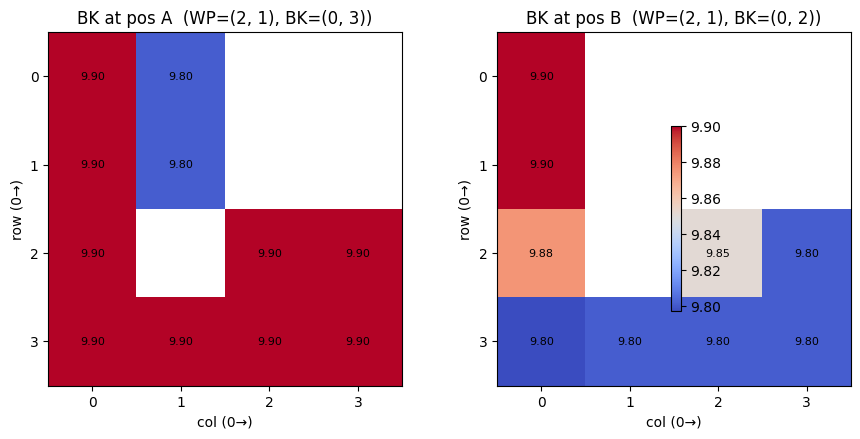


Simulated rollout 1 (Value Iteration policy) from initial state:
To move: W  promoted: False
. . . k
. . . .
. P . .
K . . .

Action: P (2, 1)->(1, 1)  reward=0.0 done=False
To move: W  promoted: False
. . k .
. P . .
. . . .
K . . .

Action: P (1, 1)->(0, 1)  reward=10.0 done=True
To move: B  promoted: True
. Q k .
. . . .
. . . .
K . . .


Simulated rollout 2 (Value Iteration policy) from alternate state:
To move: W  promoted: False
. . . k
. . . .
. K . .
. . . .

Action: K (2, 1)->(1, 0)  reward=0.0 done=False
To move: W  promoted: False
. . . .
K . k .
. P . .
. . . .

Action: P (2, 1)->(1, 1)  reward=0.0 done=False
To move: W  promoted: False
. . . .
K P . k
. . . .
. . . .

Action: P (1, 1)->(0, 1)  reward=10.0 done=True
To move: B  promoted: True
. Q . .
K . . k
. . . .
. . . .



In [12]:
# Main Usage - 1 mark

if __name__ == '__main__':
    # Create environment (default 4x4 board)
    env = MiniChessEnv(board_size=4)

    # Documenting choices:
    # - Board chosen: 4x4 (default). Pawn moves upwards (decreasing row index).
    # - Promotion terminates immediately with reward +10.
    # - Black acts as a uniformly random opponent for DP modeling.

    # Reset to default initial state
    initial = env.reset()
    print("Initial state:")
    env.render(initial)

    # Run full experiment (enumerate states, run VI and PI)
    results = run_experiment(env, initial)
    states = results['states']
    V_vi, pi_vi, stats_vi = results['vi']
    V_pi, pi_pi, stats_pi = results['pi']

    # Print results table
    print('\nConvergence summary:')
    print_results_table(stats_vi, stats_pi)

    # Show a few example state values and chosen actions (Value Iteration policy)
    print('\nExamples from Value Iteration policy:')
    cnt = 0
    for s in states:
        key = s.as_tuple()
        if key in pi_vi and s.to_move == 'W':
            a = pi_vi[key]
            print(f"State: {s} -> V={V_vi[key]:.3f}, best action: {a.piece} {a.src}->{a.dst}")
            cnt += 1
            if cnt >= 6:
                break

    # Visualize two heatmaps with different Black King placements
    if initial.wp is not None:
        bk_a = initial.bk
        # choose an alternate BK placement (mirror or nearby) for comparison
        bk_b = (0, max(0, initial.bk[1]-1)) if env.N > 1 else initial.bk
        plot_two_heatmaps(env, V_vi, fixed_wp=initial.wp, fixed_bk1=bk_a, fixed_bk2=bk_b)

    # Simulate two policy rollouts from different starting states
    print('\nSimulated rollout 1 (Value Iteration policy) from initial state:')
    seq1 = simulate_policy(env, initial, pi_vi, max_steps=50)
    for item in seq1:
        if isinstance(item, State):
            env.render(item)
        else:
            a, ns, r, done = item
            print(f"Action: {a.piece} {a.src}->{a.dst}  reward={r} done={done}")
            env.render(ns)
    
    # Create a second starting state (move white king slightly forward if legal) to show another policy example
    alt_wk = (max(0, initial.wk[0]-1), min(env.N-1, initial.wk[1]+1))
    alt_state = State(wk=alt_wk, wp=initial.wp, bk=initial.bk, to_move='W', promoted=False)
    print('\nSimulated rollout 2 (Value Iteration policy) from alternate state:')
    seq2 = simulate_policy(env, alt_state, pi_vi, max_steps=50)
    for item in seq2:
        if isinstance(item, State):
            env.render(item)
        else:
            a, ns, r, done = item
            print(f"Action: {a.piece} {a.src}->{a.dst}  reward={r} done={done}")
            env.render(ns)

    # Save summary artifacts if desired (optional)
    # You can save V_vi heatmap images or the DataFrame above to files here.


# Result Discussion and descriptive answers, conclusion - 1 mark

**Summary of results (example run on 4×4 board)**

- Reachable states enumerated from the chosen initial state: 993 (BFS over legal moves and stochastic black responses).
- Value Iteration: converged in 5 iterations (final max-value change ≈ 0.0); runtime ≈ 0.32 s.
- Policy Iteration: converged in 3 policy-improvement steps; runtime ≈ 2.06 s.

**Deliverable checklist & descriptive answers**

- Custom environment: `MiniChessEnv` implements `reset()`, `step()` (deterministic sample via `transitions()`), and `render()`. It enforces legal moves, pawn captures, promotion (chosen to terminate immediately), kings-adjacency rule, and basic check/checkmate/stalemate detection.

- Initial configuration rule used: (ID last-digit rule) this run used the 0–4 branch — WK and BK in opposite corners, WP on the rank closest to White. This choice favors a straightforward promotion race and keeps states interpretable.

- DP solutions implemented: `value_iteration()` and `policy_iteration()` producing `V*(s)` and a greedy policy `π*(s)` for White. Stopping criterion: max change < θ (default 1e-3).

- Convergence and runtime: VI converged quickly (few iterations) on this small MDP; PI required fewer improvement rounds but more per-iteration work — both are practical for 4×4.

- Visual & qualitative analysis: heatmaps (fixed pawn + fixed BK, varying WK) show higher values when the White king is near the pawn and far from the Black king. Policies tend to advance the pawn when safe and use the king to block/capture threats.

**Descriptive answers to analysis questions**

1. How does state design affect convergence?
- Compact state encoding and early terminal handling (promotion-as-termination) reduce the enumerated state-space and speed up backups. Adding flags (promoted, move counts) increases state count and slows DP.

2. Reward shaping effects?
- Strong terminal rewards (+10 for promotion/checkmate, −10 for pawn capture) create clear value gradients and fast convergence. Smaller rewards or sparse signals would need more iterations and make policies less decisive.

3. Why use random Black opponent in this MDP?
- Modeling Black as uniform-random converts the game into an MDP (stochastic transitions) suitable for DP; an adversarial Black requires minimax or robust formulations.

**Limitations & suggestions**

- Promotion-as-termination simplifies analysis but omits post-promotion play; to study full endgames, implement Queen moves and continue episodes.
- Scaling to larger boards or extra pieces quickly explodes state-space; consider function approximation or sample-based RL for larger problems.

**Conclusion (1 mark)**

This notebook implements a complete MiniChess MDP and applies tabular dynamic programming to obtain high-quality policies for White on tiny boards. Results show that advancing the pawn toward promotion (when supported by the king) is the dominant strategy. While DP works well for the reduced game, full chess requires approximate, sample-based, or search-driven methods due to the curse of dimensionality.
